<a target="_blank" href="https://colab.research.google.com/github/Sebelino/DD2424-project/blob/main/e1_sebastian.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
%load_ext autoreload
%autoreload 2

import os
import socket

repo_name = "DD2424-project"
dep_filename = "download_dataset.py"
cwd = os.getcwd()
hostname = socket.gethostname()

print(f"Host: {hostname}")
print(f"You are here: {cwd}")

if os.path.exists(dep_filename):
    print(f"{dep_filename} is in your current directory. Assuming you are in the root of the repository.")
elif not os.path.exists(repo_name):
    print(f"Cloning repo and fetching {dep_filename}...")
    !git clone https://github.com/Sebelino/DD2424-project
    !cp DD2424-project/download_dataset.py .
else:
    !git -C DD2424-project pull --rebase
    !cp DD2424-project/download_dataset.py .

Host: deeplearning-vm
You are here: /home/silpasoninallacheruvu/DD2424-project
download_dataset.py is in your current directory. Assuming you are in the root of the repository.


# Train model

In [ ]:
from dataclasses import asdict
from util import json_dumps
from evaluation import evaluate_test_accuracy_and_misclassified, \
    evaluate_with_train_val_plot, run_with_different_seeds, run_comparison
from run import run
%reload_ext autoreload
%autoreload 2

from determinism import Determinism

determinism = Determinism(seed=42).sow()  # Keep this before any torch import

from training import TrainParams, NagParams, AdamParams

baseline_params = TrainParams(
    seed=determinism.seed,
    batch_size=32,
    architecture="resnet50",
    n_epochs=10,
    optimizer=NagParams(
        learning_rate=0.01,
        weight_decay=1e-4,
        momentum=0.9,
    ),
    freeze_layers=True,
    unfreezing_epochs=None,
    validation_freq=1,
    unfreeze_last_l_blocks = 1,
    time_limit_seconds=None,
    val_acc_target=None,
)

invalidate_cache_entry = True
if invalidate_cache_entry:
    run.call_and_shelve(baseline_params).clear()

# First plot: Training and validation accuracy
for l in range(1,6):
    baseline_params.unfreeze_last_l_blocks = l
    print("Training with params:")
    print(baseline_params.pprint())
    result = run(baseline_params)

    print("Training result:")
    print(result.pprint())
    evaluate_with_train_val_plot(result)

    # Second plot: Rerun training multiple times with different seed
    run_with_different_seeds(baseline_params, trials=3)

    # Third plot: Compare NAG with Adam
    experimental_params = baseline_params.copy()
    experimental_params.optimizer = AdamParams(learning_rate=0.001)
    
    param_sets = {
        "Baseline (NAG)": baseline_params,
        "Experiment (Adam)": experimental_params,
    }
    
    run_comparison(param_sets, trials=3)


# Train unsupervised model

Training with params:
{
  "seed": 42,
  "architecture": "resnet50",
  "optimizer": {
    "learning_rate": 0.022630885203465553,
    "weight_decay": 8.478660307897792e-05,
    "momentum": 0.8063799868511693,
    "name": "nag"
  },
  "n_epochs": 5,
  "freeze_layers": true,
  "unfreezing_epochs": [2, 4],
  "validation_freq": 1,
  "unfreeze_last_l_blocks": 2,
  "unsup_weight": 0.3,
  "masked_finetune": false,
  "mask_K": 1,
  "contrastive_temp": 0.1
}
[Trainer] Unfroze last 2 blocks


Update step:   0%|          | 0/465 [00:00<?, ?it/s]

Epoch [1/5], Loss: 3.8767, Train Acc: 44.64%, Val Acc: 83.79%
Epoch [2/5], Loss: 1.1939, Train Acc: 75.76%, Val Acc: 85.42%
Epoch [3/5], Loss: 0.4075, Train Acc: 90.42%, Val Acc: 89.92%
Epoch [4/5], Loss: 0.2397, Train Acc: 94.59%, Val Acc: 88.42%
Epoch [5/5], Loss: 0.1762, Train Acc: 97.07%, Val Acc: 89.10%
Total elapsed: 75.91s, average per update step: 0.09s
[Trainer] Saved checkpoint to runs/checkpoints/dd224d6cb181c1017c29dfa5f24855ef.pth
Training result:
{
  "training_losses": [3.876682250229559, 1.1938957257262832, 0.4074961885477283, 0.23969418951310217, 0.176234961184673],
  "training_accuracies": [0.4464487034949267, 0.7576099210822999, 0.9041713641488163, 0.9458850056369785, 0.9706877113866967],
  "validation_accuracies": [0.837874659400545, 0.8542234332425068, 0.8991825613079019, 0.8841961852861036, 0.8910081743869209],
  "update_steps": [93, 186, 279, 372, 465],
  "epochs": [1, 2, 3, 4, 5],
  "training_elapsed": 75.91306453299967
}


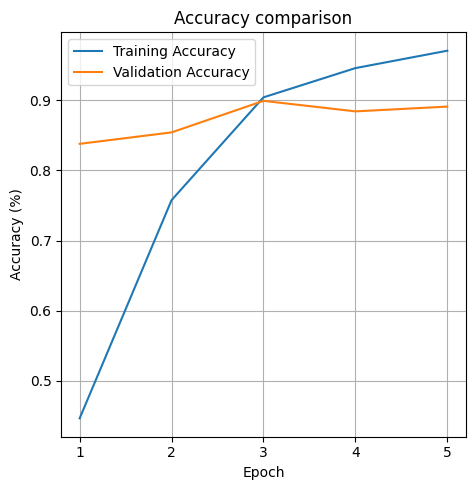

In [14]:
%reload_ext autoreload
%autoreload 2

from training import TrainParams, NagParams
from evaluation import evaluate_test_accuracy_and_misclassified, \
    evaluate_with_train_val_plot, run_with_different_seeds, run_comparison
from run import run
from caching import invalidate_cache_entry
from datasets import DatasetParams

from determinism import Determinism

determinism = Determinism(seed=42).sow()  # Keep this before any torch import
   
dataset_params = DatasetParams(
    splitting_seed=determinism.seed,
    shuffler_seed=determinism.seed,
    batch_size=32,
    trainval_size=None,  # Load all training data
    #trainval_size=400,  # Load a subset
    validation_set_fraction=0.2,  # 20 % of trainval set
    labelled_data_fraction=0.3, # full labelled data first
)

baseline_params = TrainParams(
    seed=determinism.seed,
    architecture="resnet50",
    n_epochs=5,
    optimizer=NagParams(
        learning_rate=0.022630885203465553,
        weight_decay=8.478660307897792e-05,
        momentum=0.8063799868511693,
    ),
    freeze_layers=True,
    unfreezing_epochs=(2, 4),
    validation_freq=1,
    time_limit_seconds=None,
    val_acc_target=None,
    unfreeze_last_l_blocks = 2,
    #pseudo_threshold = 0.95,
    unsup_weight = 0.3
)

run_args = (dataset_params, baseline_params)

# Set invalidate=True to invalidate a single cache entry
invalidate_cache_entry(run, run_args, invalidate=False)

# First plot: Training and validation accuracy
print("Training with params:")
print(baseline_params.pprint())
result = run(*run_args)

print("Training result:")
print(result.pprint())
evaluate_with_train_val_plot(result)

Creating balanced split...


  0%|          | 0/2946 [00:00<?, ?it/s]

[Trainer] Unfroze last 2 blocks


Update step:   0%|          | 0/465 [00:00<?, ?it/s]

Epoch [1/5], Loss: 6.2497, Train Acc: 10.47%, Val Acc: 57.22%
Epoch [2/5], Loss: 4.7921, Train Acc: 34.12%, Val Acc: 61.58%
Epoch [3/5], Loss: 3.2883, Train Acc: 50.00%, Val Acc: 65.53%
Epoch [4/5], Loss: 2.1984, Train Acc: 59.80%, Val Acc: 67.98%
Epoch [5/5], Loss: 1.4763, Train Acc: 70.27%, Val Acc: 73.98%
Total elapsed: 78.80s, average per update step: 0.11s
[Trainer] Saved checkpoint to runs/checkpoints/8456483e2b77cae590a6ca4684fa2a36.pth
[Trainer] Unfroze last 2 blocks


Update step:   0%|          | 0/465 [00:00<?, ?it/s]

Epoch [1/5], Loss: 3.7610, Train Acc: 44.64%, Val Acc: 83.38%
Epoch [2/5], Loss: 1.0890, Train Acc: 77.56%, Val Acc: 87.06%
Epoch [3/5], Loss: 0.5854, Train Acc: 88.61%, Val Acc: 90.60%
Epoch [4/5], Loss: 0.2283, Train Acc: 94.81%, Val Acc: 87.87%
Epoch [5/5], Loss: 0.1707, Train Acc: 96.39%, Val Acc: 87.87%
Total elapsed: 75.73s, average per update step: 0.09s
[Trainer] Saved checkpoint to runs/checkpoints/dd224d6cb181c1017c29dfa5f24855ef.pth
Creating balanced split...


  0%|          | 0/2946 [00:00<?, ?it/s]

[Trainer] Unfroze last 2 blocks


Update step:   0%|          | 0/465 [00:00<?, ?it/s]

Epoch [1/5], Loss: 2.7920, Train Acc: 56.54%, Val Acc: 84.74%
Epoch [2/5], Loss: 0.7119, Train Acc: 84.47%, Val Acc: 91.42%
Epoch [3/5], Loss: 0.2885, Train Acc: 93.90%, Val Acc: 91.42%
Epoch [4/5], Loss: 0.1180, Train Acc: 97.76%, Val Acc: 91.28%
Epoch [5/5], Loss: 0.1445, Train Acc: 97.22%, Val Acc: 92.78%
Total elapsed: 72.95s, average per update step: 0.10s
[Trainer] Saved checkpoint to runs/checkpoints/384cf929bbea00e387fe1bea74cfee87.pth
[Trainer] Unfroze last 2 blocks


Update step:   0%|          | 0/465 [00:00<?, ?it/s]

Epoch [1/5], Loss: 2.2177, Train Acc: 66.46%, Val Acc: 88.28%
Epoch [2/5], Loss: 0.3562, Train Acc: 90.94%, Val Acc: 90.60%
Epoch [3/5], Loss: 0.1044, Train Acc: 97.29%, Val Acc: 89.37%
Epoch [4/5], Loss: 0.0585, Train Acc: 98.69%, Val Acc: 93.60%
Epoch [5/5], Loss: 0.0259, Train Acc: 99.56%, Val Acc: 92.92%
Total elapsed: 69.06s, average per update step: 0.09s
[Trainer] Saved checkpoint to runs/checkpoints/e42aa40db95fabd3e6bf1019b6cc2042.pth
Creating balanced split...


  0%|          | 0/2946 [00:00<?, ?it/s]

[Trainer] Unfroze last 2 blocks


Update step:   0%|          | 0/465 [00:00<?, ?it/s]

Epoch [1/5], Loss: 1.8597, Train Acc: 69.40%, Val Acc: 90.46%
Epoch [2/5], Loss: 0.3198, Train Acc: 90.28%, Val Acc: 93.32%
Epoch [3/5], Loss: 0.0963, Train Acc: 97.70%, Val Acc: 93.05%
Epoch [4/5], Loss: 0.0437, Train Acc: 99.13%, Val Acc: 91.96%
Epoch [5/5], Loss: 0.0279, Train Acc: 99.47%, Val Acc: 94.14%
Total elapsed: 66.50s, average per update step: 0.10s
[Trainer] Saved checkpoint to runs/checkpoints/dbb8885d08c4651fa3a8af4e97bdacdb.pth
Creating balanced split...


  0%|          | 0/2946 [00:00<?, ?it/s]

[Trainer] Unfroze last 2 blocks


Update step:   0%|          | 0/465 [00:00<?, ?it/s]

Epoch [1/5], Loss: 1.4667, Train Acc: 74.92%, Val Acc: 89.92%
Epoch [2/5], Loss: 0.2969, Train Acc: 91.45%, Val Acc: 91.96%
Epoch [3/5], Loss: 0.0919, Train Acc: 98.00%, Val Acc: 92.23%
Epoch [4/5], Loss: 0.0451, Train Acc: 99.19%, Val Acc: 91.55%
Epoch [5/5], Loss: 0.0419, Train Acc: 99.42%, Val Acc: 92.64%
Total elapsed: 62.65s, average per update step: 0.09s
[Trainer] Saved checkpoint to runs/checkpoints/0e2578b3faeffa0a46574248057d4d41.pth


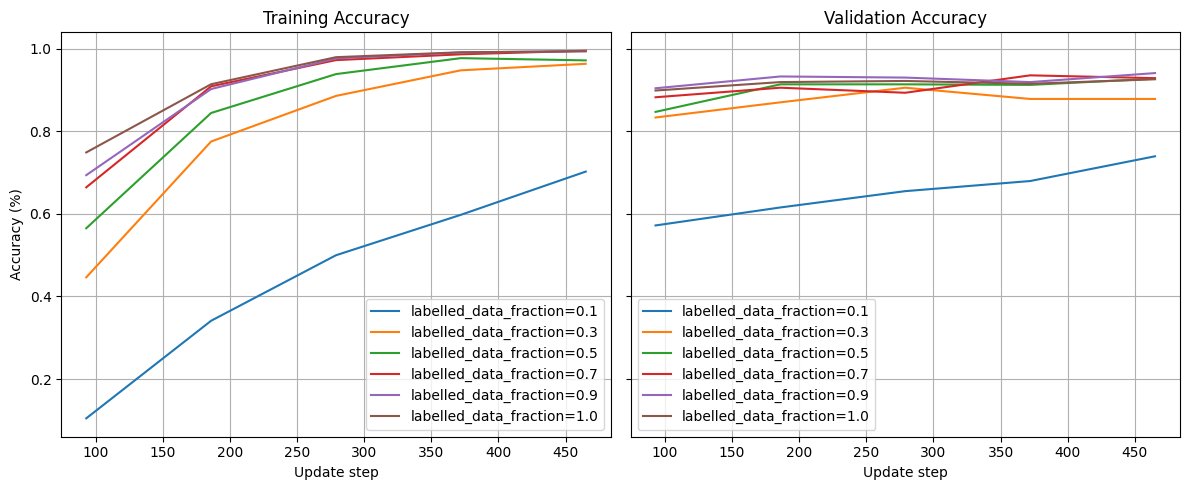

In [15]:
from evaluation import run_dataset_comparison

def tweak(params: DatasetParams, labelled_data_fraction):
    params = params.copy()
    params.labelled_data_fraction = labelled_data_fraction
    return params
 
#plot: Compare unsupervised learning for different fractions of unlabelled data
labelled_data_fractions = [ 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
param_sets = {f"labelled_data_fraction={data_fraction}": tweak(dataset_params, labelled_data_fraction=data_fraction) for data_fraction in labelled_data_fractions}

run_dataset_comparison(param_sets, baseline_params)


[Trainer] Unfroze last 2 blocks


Update step:   0%|          | 0/465 [00:00<?, ?it/s]

Epoch [1/5], Loss: 3.4365, Train Acc: 20.27%, Val Acc: 68.53%
Epoch [2/5], Loss: 2.3348, Train Acc: 77.70%, Val Acc: 78.07%
Epoch [3/5], Loss: 0.7417, Train Acc: 91.55%, Val Acc: 84.06%
Epoch [4/5], Loss: 2.9513, Train Acc: 61.82%, Val Acc: 75.89%
Epoch [5/5], Loss: 2.2902, Train Acc: 62.16%, Val Acc: 76.98%
Total elapsed: 67.83s, average per update step: 0.10s
[Trainer] Saved checkpoint to runs/checkpoints/713c1b215f5272cf083cac17190b8b2b.pth
[Trainer] Unfroze last 2 blocks


Update step:   0%|          | 0/465 [00:00<?, ?it/s]

Epoch [1/5], Loss: 2.6859, Train Acc: 48.48%, Val Acc: 85.29%
Epoch [2/5], Loss: 0.6468, Train Acc: 91.09%, Val Acc: 91.14%
Epoch [3/5], Loss: 1.0200, Train Acc: 84.10%, Val Acc: 91.14%
Epoch [4/5], Loss: 0.2872, Train Acc: 94.02%, Val Acc: 88.56%
Epoch [5/5], Loss: 0.1132, Train Acc: 96.73%, Val Acc: 90.87%
Total elapsed: 65.22s, average per update step: 0.09s
[Trainer] Saved checkpoint to runs/checkpoints/9932ed0f2191df20d1181d791c2b0b9a.pth
[Trainer] Unfroze last 2 blocks


Update step:   0%|          | 0/465 [00:00<?, ?it/s]

Epoch [1/5], Loss: 2.1690, Train Acc: 62.24%, Val Acc: 86.78%
Epoch [2/5], Loss: 0.4217, Train Acc: 90.37%, Val Acc: 90.05%
Epoch [3/5], Loss: 0.1652, Train Acc: 96.20%, Val Acc: 91.83%
Epoch [4/5], Loss: 0.0623, Train Acc: 98.85%, Val Acc: 90.74%
Epoch [5/5], Loss: 0.0950, Train Acc: 98.64%, Val Acc: 92.23%
Total elapsed: 65.37s, average per update step: 0.09s
[Trainer] Saved checkpoint to runs/checkpoints/821e2f35f31c6ec6d6ae065748fcf1fe.pth
[Trainer] Unfroze last 2 blocks


Update step:   0%|          | 0/465 [00:00<?, ?it/s]

Epoch [1/5], Loss: 1.7739, Train Acc: 69.66%, Val Acc: 90.33%
Epoch [2/5], Loss: 0.7379, Train Acc: 86.23%, Val Acc: 90.05%
Epoch [3/5], Loss: 0.1428, Train Acc: 95.69%, Val Acc: 93.05%
Epoch [4/5], Loss: 0.0421, Train Acc: 99.18%, Val Acc: 94.01%
Epoch [5/5], Loss: 0.0251, Train Acc: 99.56%, Val Acc: 94.28%
Total elapsed: 65.85s, average per update step: 0.09s
[Trainer] Saved checkpoint to runs/checkpoints/93d3e62299defbf9b825e0982e320e1d.pth
[Trainer] Unfroze last 2 blocks


Update step:   0%|          | 0/465 [00:00<?, ?it/s]

Epoch [1/5], Loss: 1.5523, Train Acc: 72.04%, Val Acc: 91.28%
Epoch [2/5], Loss: 0.3408, Train Acc: 90.69%, Val Acc: 92.23%
Epoch [3/5], Loss: 0.0761, Train Acc: 98.04%, Val Acc: 94.01%
Epoch [4/5], Loss: 0.0315, Train Acc: 99.43%, Val Acc: 94.41%
Epoch [5/5], Loss: 0.0157, Train Acc: 99.89%, Val Acc: 94.14%
Total elapsed: 64.64s, average per update step: 0.10s
[Trainer] Saved checkpoint to runs/checkpoints/7a0918dea644fd230aee8fd10aa5dbc7.pth
[Trainer] Unfroze last 2 blocks


Update step:   0%|          | 0/465 [00:00<?, ?it/s]

Epoch [1/5], Loss: 1.4617, Train Acc: 75.59%, Val Acc: 90.46%
Epoch [2/5], Loss: 0.2959, Train Acc: 91.68%, Val Acc: 92.23%
Epoch [3/5], Loss: 0.0907, Train Acc: 98.00%, Val Acc: 92.10%
Epoch [4/5], Loss: 0.0460, Train Acc: 99.12%, Val Acc: 92.37%
Epoch [5/5], Loss: 0.0394, Train Acc: 99.36%, Val Acc: 92.23%
Total elapsed: 63.78s, average per update step: 0.09s
[Trainer] Saved checkpoint to runs/checkpoints/53c6a106fae42ef098e450ef372cc31e.pth


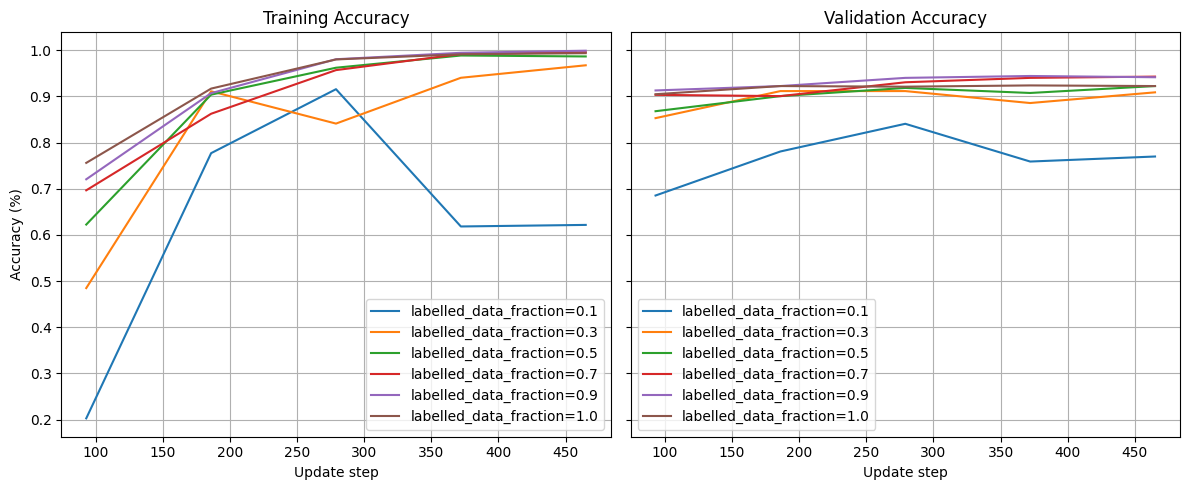

In [16]:
from evaluation import run_dataset_comparison

def tweak(params: DatasetParams, labelled_data_fraction):
    params = params.copy()
    params.labelled_data_fraction = labelled_data_fraction
    return params
 
#plot: Compare unsupervised learning for different fractions of unlabelled data along with threshold
labelled_data_fractions = [ 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
param_sets = {f"labelled_data_fraction={data_fraction}": tweak(dataset_params, labelled_data_fraction=data_fraction) for data_fraction in labelled_data_fractions}

baseline_params.pseudo_threshold = 0.95
run_dataset_comparison(param_sets, baseline_params)


# Test model

In [ ]:
from training import FinishedAllEpochs, Trainer
from datasets import make_datasets, load_dataset
from torch.utils.data import DataLoader

training_params = baseline_params

print("Training with params:")
print(training_params.pprint())
trainer = Trainer(training_params)
labelled_train_loader, unlabelled_train_loader, val_loader = make_datasets(dataset_params, trainer.transform)
trainer.load_dataset(labelled_train_loader, unlabelled_train_loader, val_loader)
trainer.train(stop_condition=FinishedAllEpochs())

training_params.data_augmentation = "false"
test_dataset = load_dataset("test", Trainer.make_transform(training_params))
test_loader = DataLoader(
    test_dataset,
    batch_size=dataset_params.batch_size,
    shuffle=False,
    num_workers=3,
    worker_init_fn=Determinism.data_loader_worker_init_fn(training_params.seed),
)
print(f"Test size: {len(test_loader.dataset)}")

evaluate_test_accuracy_and_misclassified(trainer, test_loader, test_dataset)